In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown

file_id = "1KF0yBrF2_FcdJ1XhFyUsjYAHJC7qMpVl"
output_file = "data_DoS.csv"

if not os.path.exists(output_file):
    gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output_file, quiet=False)

file_id = "1_GXC-sVehXrvsLDHVHie6fdeIISlBV2z"
output_file = "data_Web.csv"

if not os.path.exists(output_file):
    gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output_file, quiet=False)

# Load the data
data_DoS = pd.read_csv("data_DoS.csv")
data_Web = pd.read_csv("data_Web.csv")

#concatenate the data
data = pd.concat([data_DoS, data_Web])

# Display the first 5 rows of the data
data.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


##### Exploratory Data Analysis

In [118]:
print(f"Features: {data.columns[:-1]}")
print(f"Target: {data.columns[-1]}")

print(f"Number of data points: {len(data)}")

print(f"Number of features: {len(data.columns) - 1}")


Features: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Va

In [119]:
#handle NaN values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

counts = data[data.columns[-1]].value_counts()
print(counts)

 Label
BENIGN                        607734
DoS Hulk                      230124
DoS GoldenEye                  10293
DoS slowloris                   5796
DoS Slowhttptest                5499
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


 Label
BENIGN                        607734
DoS Hulk                      230124
DoS GoldenEye                  10293
DoS slowloris                   5796
DoS Slowhttptest                5499
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


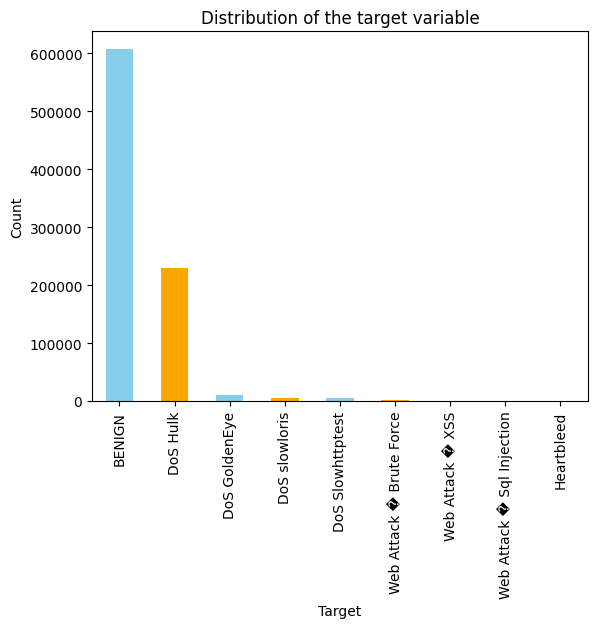

In [120]:
# Check for class imbalances
# Display the distribution of the target variable
counts = data[data.columns[-1]].value_counts()
print(counts)
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of the target variable')
plt.show()

We want to focus specifially on DoS attacks, so we will filter out the Heartbleed, one because it is not a DoS attack and two because it is only present 11 times.

In addition, we will also combine the different types of DoS attacks into one category, as DoS Hulk (HTTP-Unbearable-Load-King) is the most common and greatly outnumber the other classes of DoS attacks present in the dataset.

To attempt to account for some of the class imbalance, we will combine the different types of Web Attacks as well.

 Label
BENIGN        607734
DoS           607734
Web Attack    607734
Name: count, dtype: int64


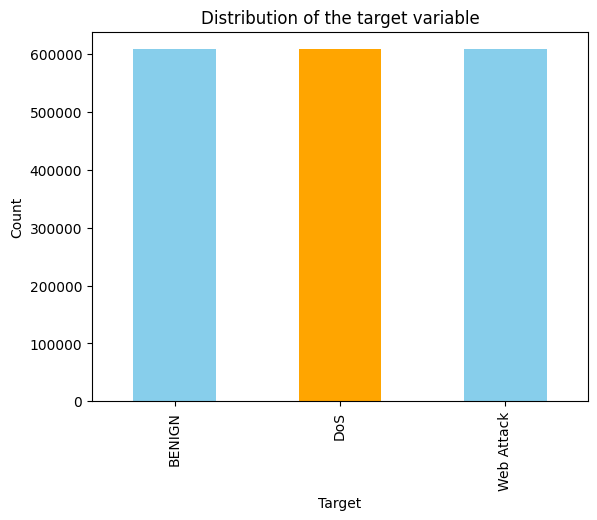

In [121]:
#handle class imbalance
#remove rows with class "Heartbleed"
data = data[data[data.columns[-1]] != "Heartbleed"]

#combine all remaining DoS classes into one class
data[data.columns[-1]] = data[data.columns[-1]].replace(["DoS Hulk", "DoS GoldenEye", "DoS slowloris", "DoS Slowhttptest"], "DoS")
data[data.columns[-1]] = data[data.columns[-1]].replace(["Web Attack � Brute Force", "Web Attack � XSS", "Web Attack � Sql Injection"], "Web Attack")

# Run SMOTE to upsample Web Attack class
from imblearn.over_sampling import SMOTE

# Separate the features and target variable
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

# Apply SMOTE
smote = SMOTE(sampling_strategy='not majority')
X, y = smote.fit_resample(X, y)

# Display the distribution of the target variable after SMOTE
counts = y.value_counts()
print(counts)

# Display the distribution of the target variable
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of the target variable')
plt.show()

In [122]:
# Run ANOVA F-test to select the top k features
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2

# Select the top 10 features
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get the selected feature indices
selected_features = selector.get_support(indices=True)

# Get the selected feature names
X.columns[selected_features]

# Display the selected features
selected_features = X.columns[selected_features]
print(selected_features)



/opt/anaconda3/envs/CSC487/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/CSC487/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['Bwd Packet Length Max', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Packet Length Std', ' PSH Flag Count',
       ' Avg Bwd Segment Size', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', 'Idle Mean', ' Idle Max'],
      dtype='object')


We can see based on the selected features that Packet Length is responsible for a majority of the variance, which makes sense as the size of the packet is a key feature in determining a given attack.

{dtype('O'), dtype('float64'), dtype('int64')}
[8.18287354e-01 8.47422724e-02 4.11282440e-02 3.14142222e-02
 1.32878713e-02 4.58660855e-03 2.80452855e-03 1.25358572e-03
 5.79901663e-04 5.37266937e-04 4.83634107e-04 3.29074191e-04
 1.91208861e-04 1.13130095e-04 9.79646304e-05 5.07453167e-05
 4.45293086e-05 2.05203679e-05 1.24792952e-05 1.21467063e-05
 1.02730045e-05 7.57406857e-06 1.99659468e-06 1.36350848e-06
 7.79479987e-07 5.62133464e-07 6.64344228e-08 6.50119764e-08
 1.16279491e-08 9.53932352e-09 4.60325385e-09 2.93969410e-09
 1.84263657e-09 6.06937426e-10 4.87580490e-11 4.66188418e-11
 1.89744042e-11 1.27981760e-11 6.12862263e-12 9.83546711e-13
 5.45823640e-13 3.13897199e-13 2.43723161e-13 1.36884880e-13
 1.10470552e-13 7.94311924e-14 4.55351494e-14 2.20161802e-14
 9.93049267e-15 5.94938507e-15 2.31513185e-15 1.68490071e-15
 6.82443659e-16 3.69769977e-17 9.11768199e-18 8.02622773e-18
 3.98512990e-18 2.71985064e-18 2.14713917e-18 2.02749177e-18
 6.19290448e-19 1.15322361e-19 2.49558

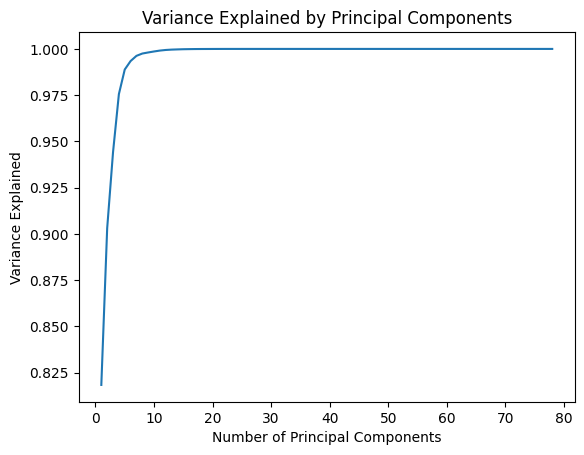

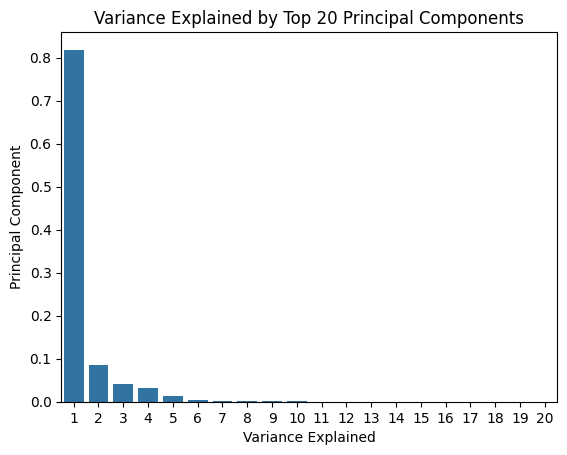

In [129]:
from sklearn.decomposition import PCA

#check data types of each column
types = []
for column in data.columns:
    types.append(data[column].dtype)

print(set(types))


# Analyze the variance explained by each principal component
pca = PCA()
pca.fit(X)

# Plot the variance explained by each principal component

print(pca.explained_variance_ratio_)
plt.plot(range(1, len(X.columns) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.show()

#plot the top 20 features
import seaborn
seaborn.barplot(x=range(1, 21), y=pca.explained_variance_ratio_[:20])
plt.xlabel('Variance Explained')
plt.ylabel('Principal Component')
plt.title('Variance Explained by Top 20 Principal Components')
plt.show()


In [135]:
# Determine Number of Feautures to Keep to ensure 99 percent of variance is explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_over_99 = len(cumulative_variance[cumulative_variance < .99])

print(f"Number of features to retain 99% variance: {n_over_99}")

# Perform PCA with the number of features determined above
pca = PCA(n_components=n_over_99)
pca.fit(X)
transformed_data = pca.transform(X)

# Convert the transformed data into a DataFrame with column names
transformed_data = pd.DataFrame(transformed_data)



# Add the target column to the transformed data
transformed_data['Label'] = y.values

# Display the first 5 rows of the transformed data
transformed_data.head()

Number of features to retain 99% variance: 5


,0,1,2,3,4,Label
0,-5.968589e+07,-1.494681e+06,-1.107273e+06,-4.337393e+06,-851518.342435,BENIGN
1,-5.972039e+07,-1.494519e+06,-6.795969e+04,-4.317015e+06,-862296.133641,BENIGN
2,-5.974076e+07,-1.509057e+06,4.643513e+06,-4.165138e+06,-860795.962371,BENIGN
3,-5.968675e+07,-1.479711e+06,-4.419784e+05,-4.327760e+06,-874544.003864,BENIGN
4,-5.974035e+07,-1.509428e+06,4.661188e+06,-4.164849e+06,-861700.026428,BENIGN


By doing PCA, we have created 5 new features that are linear combinations of the original features.

#### Data Preprocessing and Preparation
We need to create two different datasets, one for training and the other for testing. Since we have a very large dataset, we can afford to keep 10% of the data for validation, 10% for testing, and 80% for training.

We will also standardize the data, to center the data around its mean and scale it base on the standard deviation.


In [136]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_data[transformed_data.columns[:-1]], transformed_data['Label'], test_size=0.2, random_state=0)

# Split the test data into testing and validation sets
validation_X = X_test.sample(frac=0.5, random_state=0)
testing_X = X_test.drop(validation_X.index)

validation_y = y_test.loc[validation_X.index]
testing_y = y_test.loc[testing_X.index]

# Display the number of data points in the training set
print(f"Number of data points in the training set: {len(transformed_data)}")
print(f"Number of data points in the testing set: {len(testing_X)}")
print(f"Number of data points in the validation set: {len(validation_X)}")




Number of data points in the training set: 1823202
Number of data points in the testing set: 182321
Number of data points in the validation set: 182320


#### Model Selection

We will use two different types of models, Neural Networks and Random Forests, to predict the type of attack. We will use the F1 score as the metric to evaluate the models.

#### Random Forest Classifier

We will start with the Random Forest Classifier, a collection of Decision Trees that will each output a prediction and the model will take the majority vote as the final prediction.

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a Random Forest classifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rfc.predict(testing_X)

# Make predictions on the training set (to check for overfitting)
train_y_pred = rfc.predict(X_train)


In [138]:
# Calculate the train accuracy of the classifier
train_accuracy = accuracy_score(y_train, train_y_pred)
print(f"Training Accuracy: {train_accuracy}\n")

# Calculate the test accuracy of the classifier
accuracy = accuracy_score(testing_y, y_pred)
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision_score(testing_y, y_pred, average='weighted')}")
print(f"Testing Recall: {recall_score(testing_y, y_pred, average='weighted')}")
print(f"Testing F1 Score: {f1_score(testing_y, y_pred, average='weighted')}")

Training Accuracy: 0.9988920586797535

Testing Accuracy: 0.9959631638703167
Testing Precision: 0.9959641096709468
Testing Recall: 0.9959631638703167
Testing F1 Score: 0.9959625864265491


This accuracy is abnormally high, so we can try to improve the model by using a Neural Network.

It is possible that the characteristics of these kind of attacks are very apparent in the data, so we could test the model on a diferent dataset of other kinds of attacks to see if the model works on those.

#### Neural Network
To train the Neural Network, we will start by creating a TensorDataset object for both the train and test sets. We will use the DataLoader object to load the data in batches.